In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import math

import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage
from scipy.stats import hypergeom
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.stats.multitest import multipletests

import matplotlib.patches as patches
from matplotlib.lines import Line2D

from openpyxl import load_workbook, Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import PatternFill

from copy import copy 

In [2]:
def format_date(x):
    """Adjust genes from date back to str for March and September"""
    if isinstance(x, datetime.datetime):
        if x.month == 3:  # March
            return f'MARCHF{x.day}'
        elif x.month == 9:  # September
            return f'SEPTIN{x.day}'
    return x

In [3]:
def make_col(df):
    """Fill in cols with NA for df"""
    clusters = df['cluster'].unique()
    data_dict = {
        cluster: df[df['cluster'] == cluster].index.tolist()
        for cluster in clusters
    }
    max_len = max(len(genes) for genes in data_dict.values())

    for cluster, genes in data_dict.items():
        data_dict[cluster] = genes + [np.nan] * (max_len - len(genes))

    return pd.DataFrame.from_dict(data_dict, orient='index').transpose()

In [4]:
ACM_gene_path = "../thesis/DGE_genelist_RBT.xlsx"

sig_lung_path = "ovelrap/lung_paper_complete_T.xlsx"
lung_names_path = "ovelrap/overlaps_lung_ptb rlm.xlsx"
sig_lep_path = "ovelrap/Supplementary_Table2.xlsx"
sig_ptb_path = "ovelrap/Complete_lists all_TC_macrophage.xlsx"

lung_output_path = "plots/lung_overlaps.png"
lep_output_path = "plots/leprosy_overlaps.png"
ptb_output_path = "plots/ptb_overlaps.png"

lung_star_path = "plots/lung_star_overlaps.png"
lep_star_path = "plots/leprosy_star_overlaps.png"
ptb_star_path = "plots/ptb_star_overlaps.png"
micro_star_path = "plots/micro_star_overlaps.png"
microXptb_star_path = "plots/microXptb_star_overlaps.png"

lung_hist_path = "plots/lung_minmax_hist.png"
lep_hist_path = "plots/lep_minmax_hist.png"
ptb_hist_path = "plots/ptb_minmax_hist.png"

lung_xls_path = "plots/lung_overlaps.xlsx"
lep_xls_path = "plots/leprosy_overlaps.xlsx"
ptb_xls_path = "plots/ptb_overlaps.xlsx"
micro_xls_path = "plots/micro_overlaps.xlsx"
microXptb_xls_path = "plots/microXptb_overlaps.xlsx"

In [5]:
# Read in lung signatures and rename columns
sig_lung = pd.read_excel(sig_lung_path)

lung_names = pd.read_excel(
    lung_names_path,
    sheet_name="jacc",
    index_col=0
)

cluster_dict = lung_names.loc[np.nan].to_dict()
inv_dict = {v: k for k, v in cluster_dict.items()}

sig_lung = sig_lung.rename(columns=inv_dict)
sig_lung = sig_lung.map(format_date)
sig_lung.head()

,1 club,1 (SS2) club,2 ciliated,2 (SS2) ciliated,3 ciliated,4 Basal,4 (SS2) Basal,5 Proximal Basal,6 Differen Basal,6 (SS2),...,52 (SS2) IGSF21+ DC,53 EREG+ DC,54 TREM2,55 ClMono,55 (SS2) ClMono,56 OLR1+ Mono,57 NC Mono,57 (SS2) NC Mono,58 Int Mono,58 (SS2) Int Mono
0,SCGB3A2,SCGB3A2,TMEM190,C20orf85,TUBB4B,KRT17,KRT17,PRSS23,PABPC1,SERPINB3,...,FOLR2,RAB31,APOE,S100A8,VCAN,SOD2,LST1,SMIM25,IFITM3,RAB7B
1,CYP2B7P,MGP,CAPS,TUBA4B,DYNLT1,S100A2,MIR205HG,KRT15,RPLP0,PRSS23,...,RNASE1,NAMPT,LIPA,S100A9,FCN1,TIMP1,FCGR3A,AC104809.2,LILRB2,MMP19
2,MGP,VIM,C9orf24,C9orf24,DYNLL1,MIR205HG,IGFBP2,AQP3,SERPINB3,SLC9A3R1,...,SLCO2B1,CLEC5A,TREM2,S100A12,LYZ,AQP9,LINC01272,CSF1R,LST1,MS4A4A
3,RPLP2,CTSE,C20orf85,TEKT1,UFC1,SERPINF1,KRT15,MIR205HG,RPSA,LSP1,...,MRC1,CTSB,GPNMB,VCAN,CD14,MARCKS,IFITM3,TCF7L2,COTL1,GNA15
4,RNASE1,RNASE1,TPPP3,ZMYND10,TUBA1A,FHL2,DLK2,KRT5,SLC25A6,ADH1C,...,C1QC,IER3,CHI3L1,LYZ,TNFAIP2,ATP13A3,AIF1,MS4A7,CD300E,CXCL3


In [6]:
# Read in leprosy signature tables
sig_lep_ct = pd.read_excel(
    sig_lep_path,
    sheet_name="Cell type markers",
    index_col=0
)
sig_lep_tc = pd.read_excel(
    sig_lep_path,
    sheet_name="T cell subtype markers",
    index_col=0
)
sig_lep_my = pd.read_excel(
    sig_lep_path,
    sheet_name="Myeloid subtype markers",
    index_col=0
)
sig_lep_kt = pd.read_excel(
    sig_lep_path,
    sheet_name="Keratinocyte subtype marker",
    index_col=0
)
sig_lep_fb = pd.read_excel(
    sig_lep_path,
    sheet_name="Fibroblast subtype markers",
    index_col=0
)
sig_lep_ed = pd.read_excel(
    sig_lep_path,
    sheet_name="Endothelial subtype markers",
    index_col=0
)

# Date to gene name 
for df in (sig_lep_ct, sig_lep_tc, sig_lep_my,
           sig_lep_kt, sig_lep_fb, sig_lep_ed):
    df["gene"] = df["gene"].apply(format_date)
    df.rename(
        index={idx: df["gene"].loc[idx] for idx in df.index},
        inplace=True
    )
    

In [7]:
# Filter by pval
sig_lep_ct = sig_lep_ct[sig_lep_ct.p_val_adj < 0.05]
sig_lep_tc = sig_lep_tc[sig_lep_tc.p_val_adj < 0.05]
sig_lep_my = sig_lep_my[sig_lep_my.p_val_adj < 0.05]
sig_lep_kt = sig_lep_kt[sig_lep_kt.p_val_adj < 0.05]
sig_lep_fb = sig_lep_fb[sig_lep_fb.p_val_adj < 0.05]
sig_lep_ed = sig_lep_ed[sig_lep_ed.p_val_adj < 0.05]


sig_lep_ct = make_col(sig_lep_ct)

sig_lep_tc = make_col(sig_lep_tc)
sig_lep_tc.rename(
    columns={col: f"TCL {col}" for col in sig_lep_tc.columns},
    inplace=True
)

sig_lep_my = make_col(sig_lep_my)
sig_lep_my.rename(
    columns={col: f"MYL {col}" for col in sig_lep_my.columns},
    inplace=True
)

sig_lep_kt = make_col(sig_lep_kt)
sig_lep_kt.rename(
    columns={col: f"KRT {col}" for col in sig_lep_kt.columns},
    inplace=True
)

sig_lep_fb = make_col(sig_lep_fb)
sig_lep_fb.rename(
    columns={col: f"FBR {col}" for col in sig_lep_fb.columns},
    inplace=True
)

sig_lep_ed = make_col(sig_lep_ed)
sig_lep_ed.rename(
    columns={col: f"END {col}" for col in sig_lep_ed.columns},
    inplace=True
)

# Concatenate all signatures into one DataFrame with filled-in NAs 
sig_lep = pd.concat(
    [sig_lep_ct, sig_lep_tc, sig_lep_my,
     sig_lep_kt, sig_lep_fb, sig_lep_ed],
    axis=1
)
sig_lep.reset_index(drop=True, inplace=True)

sig_lep.head()

,B cell,Plasma cell,Myeloid,Langerhans,T cell,Mast cell,Keratinocyte,Fibroblast,Smooth muscle,Endothelial,...,FBR 0,FBR 1,FBR 2,FBR 3,END 0,END 1,END 2,END 3,END 4,END 5
0,MS4A1,IGHM,LYZ,FCGBP,TTN,TPSB2,KRT14,C3,MYH11,PECAM1,...,COL6A3,GSN,CXCL2,ADAM12,SPARCL1,SEMA3G,ZFP36,RAB3C,CCL21,CCL8
1,BANK1,IGHG1,FTL,HLA-DQB2,CCL5,CPA3,KRT2,DCN,ACTA2,VWF,...,COL6A1,MGP,C11orf96,COL11A1,AQP1,CXCL12,ICAM4,RPS4Y1,TFF3,DKK2
2,CD37,IGKC,CHIT1,CD207,RNF213,CTSG,KRT5,COL3A1,TAGLN,AQP1,...,COL3A1,CFD,HSPA1A,POSTN,ACKR1,PODXL,ICAM1,ADGRG6,PROX1,KCNJ2
3,CD79A,IGLC2,CTSB,FCER1A,IL7R,TPSAB1,DMKN,COL1A2,RGS5,SPARCL1,...,COL6A2,C7,NFKBIA,WNT2,CD74,IGFBP3,JUNB,RPL23A,LYVE1,CXCL8
4,WDFY4,IGHG4,CXCL8,CD1A,IFNG,GATA2,PERP,CCDC80,MYL9,A2M,...,COL1A2,APOD,TUBB2A,SULF1,PLVAP,SLC9A3R2,TNFAIP3,MEOX2,EFEMP1,C2CD4A


In [8]:
# Read in scRNA-seq gene lists for PTB
df_all = pd.read_excel(
    sig_ptb_path,
    sheet_name="all"
)
df_tc = pd.read_excel(
    sig_ptb_path,
    sheet_name="T cells"
)
df_mc = pd.read_excel(
    sig_ptb_path,
    sheet_name="macrophage"
)

# Concatenate all signatures into one DataFrame with filled-in NAs 
sig_ptb = pd.concat(
    [df_all, df_tc, df_mc],
    axis=1
)

# Preview the result
sig_ptb.head()

,macrophage,AET2,lung FB,T cells,plasma cells,vascular EC,B cells,AET1,proliferating,Mast Cell,...,mixed,monocyte,TREM2 macrophage,SPP1+ macrophage,alveolar macrophage,insterstitial macrophage,IFN-activated macrophage,myoFB,migratory LC,LAMP3+ DCs
0,MCEMP1,AGBL1,COL11A1,KLRC1,IGHG1,VWF,MS4A1,RTKN2,KIF18B,MS4A2,...,CNIH3,S100A12,TSPAN10,GAL,GPD1,PLEKHG5,CXCL11,DOC2B,SYT2,CHGA
1,OLR1,SCN1A,SFRP4,KLRC3,IGHA1,CA4,FCRL1,SCEL,HJURP,TPSG1,...,FMN2,NFE2,HS3ST2,SPP1,FABP4,MAMDC2,PLA2G2D,PRSS12,CDH20,TNNT2
2,SPP1,ROS1,SCARA5,KLRC4,IGLC1,PTPRB,PAX5,MS4A15,MKI67,CPA3,...,GOLGA8R,LIPN,CHRNA1,CP,C8B,LYVE1,PCDHGB6,ARHGAP28,CDH17,TFPI2
3,ATP6V0D2,AGTR2,STEAP2,KLRK1,JCHAIN,SELE,FCER2,BDNF,DLGAP5,SLC18A2,...,CLEC3B,NEURL1,TMEM255A,KCP,ARHGEF28,TNFRSF25,TNFRSF4,PHYHIP,FCER1A,TYR
4,SLC11A1,CAPN8,CILP,GNLY,AMPD1,RAMP3,BLK,NTM,ASPM,HDC,...,CBLIF,MGAM,SIGLEC8,MMP12,MOGAT1,CCDC141,CPSF4L,IGSF9B,CDX1,CCR7


In [9]:
# Read in core, alveoli, and mantle gene lists
ref_acm = pd.read_excel(ACM_gene_path)

ref_dict = {
    "Alveoli": pd.DataFrame(index=ref_acm["Alveoli"].values),
    "Core":    pd.DataFrame(index=ref_acm["Core"].values),
    "Mantle":  pd.DataFrame(index=ref_acm["Mantle"].values),
}

In [10]:
def compute_jacc(setA=set(), setB=set(), M=1):
    """Compute overlap count, Jaccard index, gene intersection, and pval (hypergeometric test)"""
    intersection = setA.intersection(setB)
    union = setA.union(setB)

    n = len(intersection)
    jacc = n / len(union)
    genes = intersection
    pval = hypergeom.sf(n - 1, M, len(setA), len(setB))

    return n, jacc, genes, pval

In [11]:
def get_dfs(sig, M, ref_dict=ref_dict):
    """Find overlap metrics for each reference vs each signature"""
    df_n = pd.DataFrame(columns=sig.keys())
    df_genes = pd.DataFrame(columns=sig.keys())
    df_jacc = pd.DataFrame(columns=sig.keys())
    df_pv = pd.DataFrame(columns=sig.keys())

    for ref_name, ref_df in ref_dict.items():
        ref_genes = set(ref_df.index.dropna())

        df_n.loc[ref_name] = 0
        df_jacc.loc[ref_name] = 0.0
        df_genes.loc[ref_name] = [() for _ in sig]
        df_pv.loc[ref_name] = 0.0

        for col in sig:
            sig_genes = set(sig[col].dropna())
            n, jacc, genes, pv = compute_jacc(ref_genes, sig_genes, M)

            df_n.at[ref_name, col] = n
            df_jacc.at[ref_name, col] = jacc
            df_genes.at[ref_name, col] = (genes,)
            df_pv.at[ref_name, col] = pv

    return df_n.astype(int), df_genes, df_jacc, df_pv
    

In [12]:
def writer_dfs(n, genes, jacc, pv, adj_pv, fname):
    """Write overlap count, gene set, Jaccards, pvals, adj pvals"""
    workbook = Workbook()
    workbook.remove(workbook.active)

    # Overlap counts
    ws = workbook.create_sheet(title="n")
    for col_idx, header in enumerate(n.columns, start=2):
        ws.cell(row=1, column=col_idx, value=header)
    for row_idx, (idx, row) in enumerate(n.iterrows(), start=2):
        ws.cell(row=row_idx, column=1, value=idx)
        for col_idx, value in enumerate(row, start=2):
            if pd.isna(value): continue
            ws.cell(row=row_idx, column=col_idx, value=value)

    # Gene intersections 
    ws = workbook.create_sheet(title="genes")
    for col_idx, header in enumerate(genes.columns, start=2):
        ws.cell(row=1, column=col_idx, value=header)
    for row_idx, (idx, row) in enumerate(genes.iterrows(), start=2):
        ws.cell(row=row_idx, column=1, value=idx)
        for col_idx, value in enumerate(row, start=2):
            if pd.isna(value): continue
            ws.cell(row=row_idx, column=col_idx, value=" ".join(list(value[0])))

    # Jaccard indices 
    ws = workbook.create_sheet(title="jacc")
    for col_idx, header in enumerate(jacc.columns, start=2):
        ws.cell(row=1, column=col_idx, value=header)
    for row_idx, (idx, row) in enumerate(jacc.iterrows(), start=2):
        ws.cell(row=row_idx, column=1, value=idx)
        for col_idx, value in enumerate(row, start=2):
            if pd.isna(value): continue
            cell = ws.cell(row=row_idx, column=col_idx, value=value)
            cell.fill = PatternFill(start_color=jacc_to_color(value, jacc.max().max()),
                                    end_color=jacc_to_color(value, jacc.max().max()),
                                    fill_type="solid")

    # pvals
    ws = workbook.create_sheet(title="pval")
    for col_idx, header in enumerate(pv.columns, start=2):
        ws.cell(row=1, column=col_idx, value=header)
    for row_idx, (idx, row) in enumerate(pv.iterrows(), start=2):
        ws.cell(row=row_idx, column=1, value=idx)
        for col_idx, value in enumerate(row, start=2):
            if pd.isna(value): continue
            cell = ws.cell(row=row_idx, column=col_idx, value=value)
            cell.fill = PatternFill(start_color=pvalue_to_color(value),
                                    end_color=pvalue_to_color(value),
                                    fill_type="solid")

    # adj pvals
    ws = workbook.create_sheet(title="adjpval")
    for col_idx, header in enumerate(adj_pv.columns, start=2):
        ws.cell(row=1, column=col_idx, value=header)
    for row_idx, (idx, row) in enumerate(adj_pv.iterrows(), start=2):
        ws.cell(row=row_idx, column=1, value=idx)
        for col_idx, value in enumerate(row, start=2):
            if pd.isna(value): continue
            cell = ws.cell(row=row_idx, column=col_idx, value=value)
            cell.fill = PatternFill(start_color=pvalue_to_color(value),
                                    end_color=pvalue_to_color(value),
                                    fill_type="solid")

    # Save workbook
    workbook.save(filename=fname)
    

In [13]:
def adjust_pvalues(pv_df, method='fdr_bh'):
    """Adjust pvals for multiple testing"""
    pvals = pv_df.values.flatten()
    _, qvals, _, _ = multipletests(pvals, method=method)
    
    adj_pv_df = pd.DataFrame(
        qvals.reshape(pv_df.shape),
        index=pv_df.index,
        columns=pv_df.columns
    )
    
    return adj_pv_df
    

In [14]:
def jacc_to_color(jacc, max_val):
    """Scale jaccard to red relative scale"""
    scale = jacc/ max_val

    green_blue = int(255 * (1 - scale))

    # Assemble RGB hex string
    return f"FF{green_blue:02X}{green_blue:02X}"


In [15]:
def pvalue_to_color(pvalue, min_p=1e-40, max_p=0.05):
    """Scale pval to red relative log scale"""
    pvalue = max(pvalue, min_p)

    log_p = -math.log10(pvalue)
    log_min = -math.log10(min_p)
    log_max = -math.log10(max_p)

    scale = (log_p - log_max) / (log_min - log_max)
    scale = max(0, min(1, scale))  
    
    # Assemble RGB hex string
    green_blue = int(255 * (1 - scale))
    return f"FF{green_blue:02X}{green_blue:02X}"
    

In [16]:
def stars(q):
    """Scale pval to * level"""
    if q < 1e-10:
        return '***'
    elif q < 1e-6:
        return '**'
    elif q < 1e-2:
        return '*'
    else:
        return ''

In [17]:
# Total genes in GeoMx WTA 
M_geomx = 18677

In [18]:
# Compute overlap DataFrames
lung_dfs = get_dfs(sig_lung, M=M_geomx)
lep_dfs = get_dfs(sig_lep,  M=M_geomx)
ptb_dfs = get_dfs(sig_ptb,  M=M_geomx)

In [19]:
def plot_heatmap(
    df,
    filename,
    cmap,
    xsize=10,
    ysize=20,
    cor="pearson",
    legendx=1,
    legendy=1,
    annot=None,            
    annot_kws=None        
):
    """Generate and save a clustered heatmap with Jaccard distances optionally overlaying significance as *"""

    figsize = (xsize, ysize)

    # Compute distance matrix (pearson, spearman, kendall)
    if cor == "spearman":
        dist_mat = ssd.pdist(
            df,
            metric=lambda u, v: (1 - spearmanr(u, v).correlation) / 2
        )
    elif cor == "kendall":
        dist_mat = ssd.pdist(
            df,
            metric=lambda u, v: (1 - kendalltau(u, v)[0]) / 2
        )
    else:
        dist_mat = ssd.pdist(df, metric="correlation")

    # Average linkage of correlated rows of Jaccard indices
    row_linkage = linkage(dist_mat, method="average")
    row_linkage[:, 2] += 0.1

    cbar_kws = dict(ticks=[0.05, 0.15, 0.25], orientation="horizontal")
    kws = dict(cbar_kws=cbar_kws)

    g = sns.clustermap(
        df,
        col_cluster=False,
        method="average",
        row_linkage=row_linkage,
        cmap=cmap,
        figsize=figsize,
        vmax=0.26,
        vmin=0,
        dendrogram_ratio=(0.35, 0),
        **kws
    )

    # Control of cbar
    g.cax.set_position([legendx, legendy, 0.3, 0.025])
    g.ax_cbar.set_title("Jaccard", fontsize=16)

    ax = g.ax_heatmap
    clustered = g.data2d
    n_rows, n_cols = clustered.shape

    # fake legend 
    handles = [
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\;\;\,\,\text{*}<10^{-2}$"),
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\;\,\text{**}<10^{-6}$"),
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\text{***}<10^{-10}$"),
    ]

    # Draw a patch on maximum Jaccard per row 
    for row_idx in range(n_rows):
        row_values = clustered.values[row_idx]
        col_idx = row_values.argmax()
        rect = patches.Rectangle(
            (col_idx, row_idx),
            1, 1,
            fill=False,
            edgecolor="red",
            linewidth=4,
            clip_on=False,
            linestyle="-"
        )
        ax.add_patch(rect)

    # Add pval annotations from annot df 
    if annot is not None:
        leg = g.fig.legend(
            handles=handles,
            title='adj P-value',
            title_fontsize=16,
            prop={'family': 'monospace','size': 12},
            loc='upper left',
            bbox_to_anchor=(legendx + 0.5, legendy + 0.06),
            bbox_transform=g.fig.transFigure,
            fancybox=True,
            framealpha=1.0,
            frameon=True,
            labelspacing=0.6,     
            handletextpad=0.2,   
            handlelength=0,       
            borderaxespad=0.0,    
            borderpad=0.1        
        )

        frame = leg.get_frame()  
        frame.set_edgecolor('black')
        frame.set_linewidth(3)       
        frame.set_boxstyle("round,pad=0.3")  
        
        txt_kws = dict(fontsize=4, color="black", fontweight="normal")
        if annot_kws:
            txt_kws.update(annot_kws)

        clustered = g.data2d     
        for i, row_label in enumerate(clustered.index):
            for j, col_label in enumerate(clustered.columns):
                star = annot.at[row_label, col_label]
                if star:
                    ax.text(
                        j + 0.5, i + 0.55, star,
                        ha="center", va="center",
                        **txt_kws
                    )

    # Tick label resize 
    g.ax_heatmap.set_xticks(g.ax_heatmap.get_xticks())
    g.ax_heatmap.set_xticklabels(
        g.ax_heatmap.get_xticklabels(),
        rotation=90,
        ha="center",
        fontsize=16,
        va="top"
    )
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=16)

    plt.savefig(filename, bbox_inches="tight", dpi=400)
    return g

In [20]:
red_cmap = sns.light_palette("red", as_cmap=True)

In [21]:
# Get lung atlas results and filter out Smart-seq (SS) columns
df = lung_dfs[2]

df_ss2 = df[[x for x in df.keys() if "SS" in x]]
df_ss2 = df_ss2.rename(
    columns={x: "".join(x.split(" (SS2)")) for x in df_ss2.keys()}
)
df_ss2 = df_ss2.rename(
    columns={x: "".join(x.split(" (SS)")) for x in df_ss2.keys()}
)

df_10x_keys = {
        "42 Prolf NK T":    "42: Proliferating NKT cell",
        "41 NK":            "41: NK cell",
        "40 NKT":           "40: NKT cell",
        "38 CD4 Memory T":  "38: CD4+ memory T cell",
        "36 CD8 memory T":  "36: CD8+ memory T cell",
        "37 CD8 Naïve T":   "37: CD8+ naïve T cell",
        "39 CD4 Naive T":   "39: CD4+ naïve T cell",
        "34 B cell":        "34: B cell",
        "52 IGSF21+ DC":    "52: IGSF21+ DC",
        "18 CAPa":          "18: Capillary aerocyte",
        "46 platelet":      "46: Platelet",
        "15 signaling AET2":"15: Signalling AET2",
        "13 AET1":          "13: AET1",
        "14 AET2":          "14: AET2",
        "50 mDC1":          "50: DC1",
        "56 OLR1+ Mono":    "56: OLR1+ monocyte",
        "57 NC Mono":       "57: Nonclassical monocyte",
        "58 Int Mono":      "58: Intermediate monocyte",
        "55 ClMono":        "55: Classical monocyte",
        "54 TREM2":         "54: TREM2+ macrophage",
        "53 EREG+ DC":      "53: EREG+ DC",
        "51 mDC2":          "51: DC2",
        "47 MF":            "47: Macrophages",
        "48 prolif mphage": "48: Proliferating macrophage",
        "1 club ":                "1: Club",
        "2 ciliated":            "2: Ciliated",
        "3 ciliated":            "3: Proximal ciliated",
        "4 Basal":               "4: Basal",
        "5 Proximal Basal":      "5: Proximal Basal",
        "6 Differen Basal":      "6: Differen Basal",
        "7 Prolif Basal":        "7: Prolif Basal",
        "8 Goblet":              "8: Goblet",
        "9 Mucous":              "9: Mucous",
        "10 Serous":             "10: Serous",
        "11 ionocyte":           "11: Ionocyte",
        "12 Neuroendocrine":     "12: Neuroendocrine",
        "16 Artery":             "16: Artery endothelial",
        "17 Vein":               "17: Vein endothelial",
        "19 CAP":                "19: General capillary",
        "20 CAPi1":              "20: Capillary intermediate 1",
        "21 Capi 2":             "21: Capillary intermediate 2",
        "22 Bronchial Vessel 1": "22: Bronchial vessel 1",
        "23 Bronchial Vessel 2": "23: Bronchial vessel 2",
        "24 lymphatic":          "24: Lymphatic endothelial",
        "25 Airway Sm Muscle":   "25: Airway smooth muscle",
        "26 Vascular Sm Muscle": "26: Vascular smooth muscle",
        "27 MyoFB":              "27: Myofibroblast",
        "28 Fibromyocyte":       "28: Fibromyocyte",
        "29 Adventitial FB":     "29: Adventitial fibroblast",
        "30 AlvF":               "30: Alveolar fibroblast",
        "31 LipF":               "31: Lipofibroblast",
        "32 Pericyte":           "32: Pericyte",
        "33 Mesothelial":        "33: Mesothelial",
        "35 Plasma":             "35: Plasma cell",
        "44 baso mast 1":        "44: Basophil / Mast 1",
        "45 baso mast 2":        "45: Basophil / Mast 2",
        "49 pDC":                "49: pDC"
}

df_10x = df[[x for x in df.keys() if "SS" not in x]]
df_10x.rename(
    columns=df_10x_keys,
    inplace=True
)

/var/folders/yj/12xfl0vj0jncs5lnjy38jlgw0000gn/T/ipykernel_50598/1164750491.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10x.rename(


In [22]:
# Rename columns and get adj pvals 
lung_dfs = list(lung_dfs)
for i in range(4):
    lung_dfs[i] = lung_dfs[i][[x for x in lung_dfs[i].keys() if "SS" not in x]]
    lung_dfs[i].rename(
        columns=df_10x_keys,
        inplace=True
    )
lung_dfs = tuple(lung_dfs) + tuple([adjust_pvalues(lung_dfs[3])],)
writer_dfs(*lung_dfs, lung_xls_path)

/var/folders/yj/12xfl0vj0jncs5lnjy38jlgw0000gn/T/ipykernel_50598/2684953182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_dfs[i].rename(


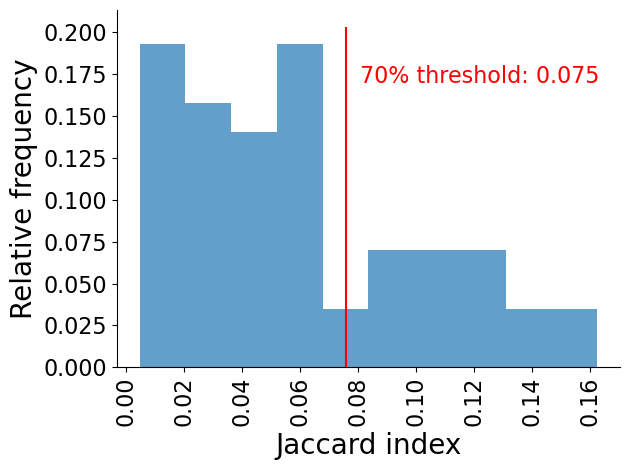

In [23]:
# Threshold max-min jaccard and plot distribution 
x = (df_10x.max(0) - df_10x.min(0))
weights = np.ones_like(x) / len(x)

counts, bins, _ = plt.hist(x, bins=10, weights=weights, alpha=0.7)

# 70th percentile quantile of Jaccards
qval=0.7
q80 = np.quantile(x, qval)

# Draw line and annotate close to quantile 
bin_centers = 0.5 * (bins[:-1] + bins[1:])
nearest_center = bin_centers[np.abs(bin_centers - q80).argmin()]
plt.vlines(nearest_center, 0, counts.max()+0.01, color="red", zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    nearest_center + 0.005,           
    counts.max() * 0.9,               
    f"{int(qval*100)}% threshold: {q80:.3f}",  
    va='center', ha='left',           
    color='red',fontsize=16
)

plt.xlabel("Jaccard index",fontsize=20)
plt.ylabel("Relative frequency",fontsize=20)
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(lung_hist_path, bbox_inches="tight", dpi=400)
plt.show()

In [24]:
# The row_bool threshold is used to filter out low quality references that do not distinguish regions
row_bool = (df_10x.max(0) - df_10x.min(0)) > q80
nrows   = df_10x.T.loc[row_bool].shape[0]
height  = 20 * nrows / 40

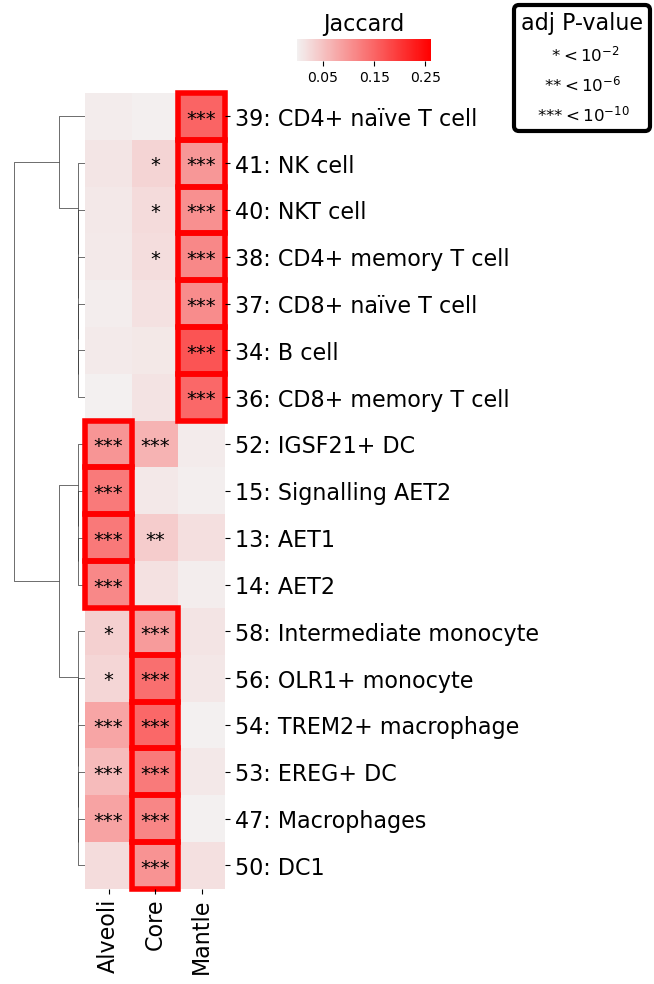

In [25]:
# Heatmap with *
plot_heatmap(
    df_10x.T.loc[row_bool],
    filename=lung_star_path,
    cmap=red_cmap,
    xsize=height / nrows / 0.675 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02,
    annot=lung_dfs[4].map(stars).T.loc[row_bool],
    annot_kws={'fontsize':14}
)

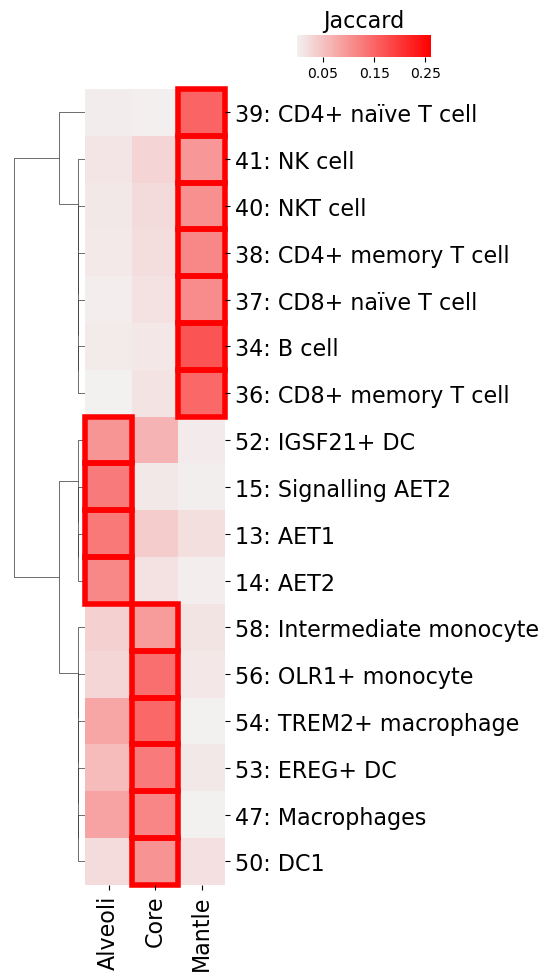

In [26]:
# Heatmap without *
plot_heatmap(
    df_10x.T.loc[row_bool],
    filename=lung_output_path,
    cmap=red_cmap,
    xsize=height / nrows / 0.675 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02
)

In [27]:
# Get leprosy overlaps
df = lep_dfs[2]

df_st = df[
    ["B cell"]
    + list(sig_lep_tc.keys())
    + list(sig_lep_my.keys())
    + list(sig_lep_fb.keys())
    + list(sig_lep_ed.keys())
]

df_st = df_st.loc[["Alveoli", "Core", "Mantle"]]

keys2 = [
    x
    for x in df_st.keys()
    if "FB" not in x and "END" not in x
]

nrows = df_st[keys2].T.shape[0]
height = 20 * nrows / 40

# We only care about myeloid and T cell subgroups + B cells 
df_st_keys = {
    "B cell":    "B cell",
    "MYL 2":     "ML2: TREM2+ macrophage (LL)",
    "MYL 3":     "ML3: Transitional macrophage",
    "MYL 4":     "ML4: M1-like macrophage (RR)",
    "MYL 0":     "ML0: DC (RR)",
    "TCL 5":     "TC5: T-reg",
    "TCL 4":     "TC4: naïve",
    "TCL 3":     "TC3: CM",
    "TCL 2":     "TC2: CTL (LL)",
    "TCL 1":     "TC1: CTL (RR)",
    "MYL 1":     "ML1: Type 1 IFN macrophage (LL)",
    "TCL 0":     "TC0: Th17 (RR)",
    "TCL 6":     "TC6: Antimicrobial CTL"
}

In [28]:
lep_dfs = list(lep_dfs)
lep_dfs = tuple(lep_dfs) + tuple([adjust_pvalues(lep_dfs[3])],)
writer_dfs(*lep_dfs, lep_xls_path)

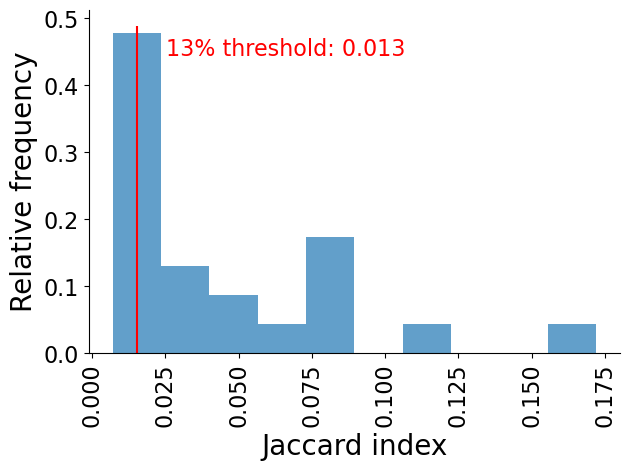

In [29]:
x = df_st.max(0)-df_st.min(0)
weights = np.ones_like(x) / len(x)

counts, bins, _ = plt.hist(x, bins=10, weights=weights, alpha=0.7)


# We do not use a threshold for Leprosy, but it would be the minimum max-min difference 
# If we were to consider it, hence quantile 13% 
qval=np.mean(x<(min(df_st[keys2].max(0)-df_st[keys2].min(0))))
q80 = (min(df_st[keys2].max(0)-df_st[keys2].min(0)))

# Draw line and annotate close to quantile 
bin_centers = 0.5 * (bins[:-1] + bins[1:])
nearest_center = bin_centers[np.abs(bin_centers - q80).argmin()]
plt.vlines(nearest_center, 0, counts.max()+0.01, color="red", zorder=2)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    nearest_center + 0.01,           
    counts.max() * 0.95,               
    f"{int(qval*100)}% threshold: {q80:.3f}",  
    va='center', ha='left',           
    color='red',fontsize=16
)

plt.xlabel("Jaccard index",fontsize=20)
plt.ylabel("Relative frequency",fontsize=20)
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(lep_hist_path, bbox_inches="tight", dpi=400)
plt.show()

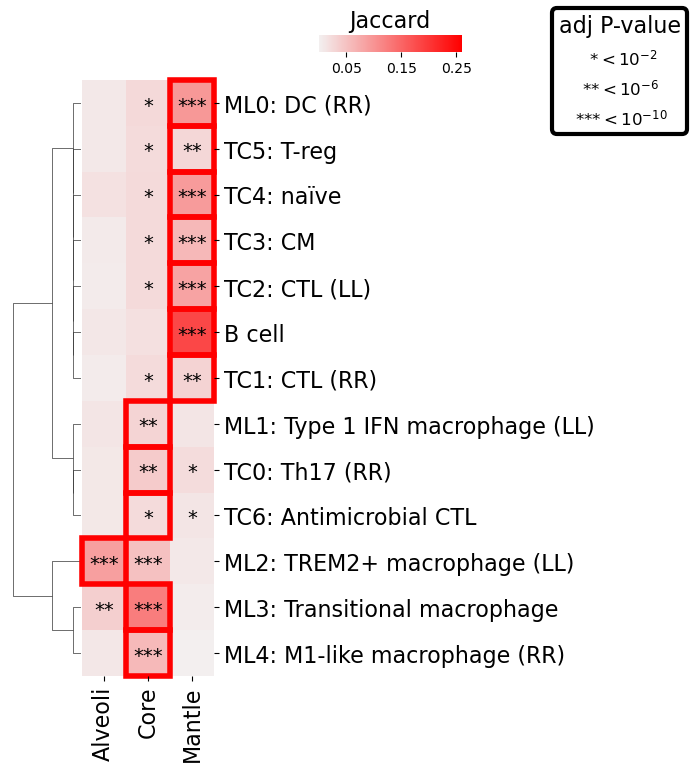

In [30]:
# Heatmap with *
# Renaming kept to just plotting to keep spreadsheet consistent with other signatures 
plot_heatmap(
    df_st[keys2]
    .rename(columns=df_st_keys)
    .T,
    cmap=red_cmap,
    filename=lep_star_path,
    xsize=height / nrows / 0.63 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02,
    annot=lep_dfs[4].map(stars)[keys2].rename(columns=df_st_keys).T,
    annot_kws={'fontsize':14}
)

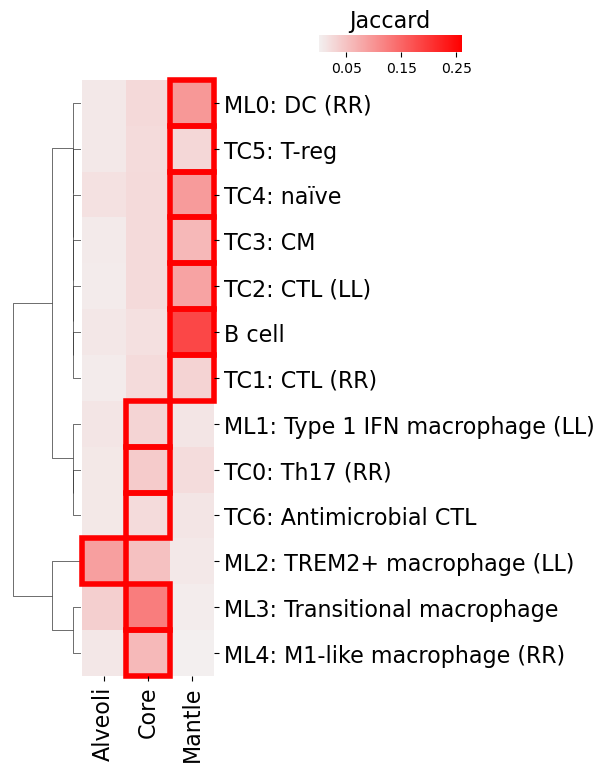

In [31]:
# Heatmap without * 
plot_heatmap(
    df_st[keys2]
    .rename(columns=df_st_keys)
    .T,
    cmap=red_cmap,
    filename=lep_output_path,
    xsize=height / nrows / 0.63 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02
)

In [32]:
# Get scRNA-seq overlap results and prepare for plotting

# Keys we care about, again no hard thresholding 
df_ptb_keys = {
    "AET2":                      "AET2",
    "AET1":                      "AET1",
    "TREM2 macrophage":          "TREM2+ macrophage",
    "alveolar macrophage":       "Alveolar macrophage",
    "insterstitial macrophage":  "Interstitial macrophage",
    "SPP1+ macrophage":          "SPP1+ macrophage",
    "CD8+ T":                    "CD8+ T cell",
    "NK":                        "NK/T-CTL/GD",
    "B cells":                   "B cell",
    "LAMP3+ DCs":                "LAMP3+ DC",
    "IFN-activated macrophage":  "IFN-activated macrophage",
    "Th17":                      "Th17 cell",
    "migratory LC":              "Migratory DC",
    "vascular EC":               "Vascular endothelial",
    "Naïve T ":                  "Naïve T cell"
}

# Keys we ignore for plotting (lower Jaccard scores) 
df_ptb_keys2 = {
    "monocyte":                  "Monocyte",
    "Treg":                      "T-reg",
    "plasma cells":              "Plasma cell",
    "macrophage":                 "Macrophage",
    "lung FB":                    "Lung fibroblast",
    "T cells":                    "T cell",
    "proliferating" :             "Proliferating",
    "Mast Cell":                  "Mast cell",
    "cDC1":                       "DC1",
    "neuron":                     "Neuron",
    "bronchial epithelial cells": "Bronchial epithelial",
    "lymphatic EC":               "Lymphatic endothelial",
    "pDC":                        "pDC",
    "mixed":                      "Mixed",
    "myoFB":                      "Myofibroblast"
}


In [33]:
# Rename scRNA-seq markers, find adj pvals, and write overlaps to file 
ptb_dfs = list(ptb_dfs)
for i in range(4):
    ptb_dfs[i].rename(
        columns=(df_ptb_keys | df_ptb_keys2),
        inplace=True
    )
ptb_dfs = tuple(ptb_dfs) + tuple([adjust_pvalues(ptb_dfs[3])],)
writer_dfs(*ptb_dfs, ptb_xls_path)

In [34]:
df_ptb = ptb_dfs[2]

# hypothetical threshold not used anymore 
row_bool = (df_ptb.max(0) - df_ptb.min(0)) > 0.03

nrows = df_ptb[list(df_ptb_keys.values())].T.shape[0]
height = 20 * nrows / 40

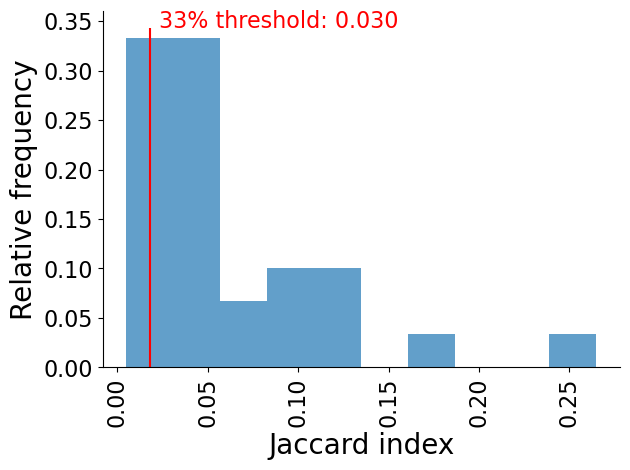

In [35]:
# Again threshold max-min but consider that 33% gives a difference of 0.03 
x = (df_ptb.max(0) - df_ptb.min(0)) 
weights = np.ones_like(x) / len(x)

counts, bins, _ = plt.hist(x, bins=10, weights=weights, alpha=0.7)

qval=0.33
q80 = np.quantile(x, qval)

# Draw and annotate line nearest to quantile 
bin_centers = 0.5 * (bins[:-1] + bins[1:])
nearest_center = bin_centers[np.abs(bin_centers - q80).argmin()]
plt.vlines(nearest_center, 0, counts.max()+0.01, color="red", zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    nearest_center + 0.005,           
    counts.max() * 1.05,               
    f"{int(qval*100)}% threshold: {q80:.3f}",  
    va='center', ha='left',           
    color='red',fontsize=16
)

plt.xlabel("Jaccard index",fontsize=20)
plt.ylabel("Relative frequency",fontsize=20)
plt.xticks(fontsize=16,rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(ptb_hist_path, bbox_inches="tight", dpi=400)
plt.show()

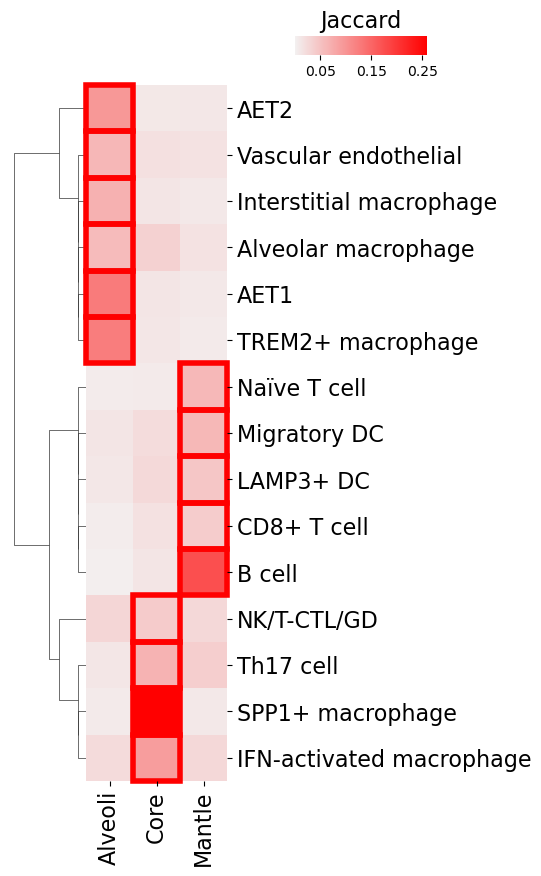

In [36]:
# Heatmap without *
ptb_hm = plot_heatmap(
    df_ptb[list(df_ptb_keys.values())]
    .T.rename(index=df_ptb_keys),
    cmap=red_cmap,
    filename=ptb_output_path,
    xsize=height / nrows / 0.68 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02
)

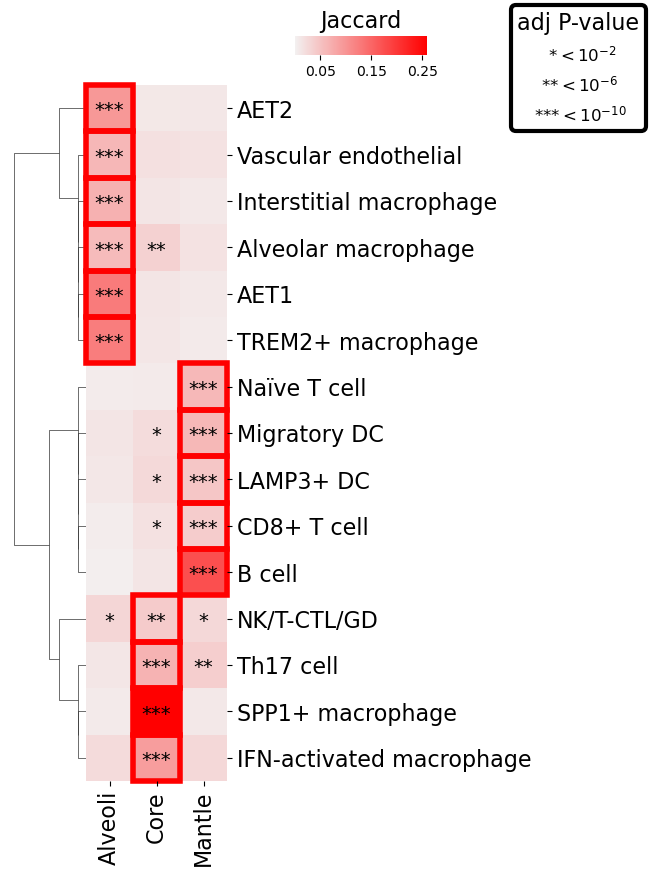

In [37]:
# Heatmap with *
plot_heatmap(
    df_ptb[list(df_ptb_keys.values())]
    .T.rename(index=df_ptb_keys),
    cmap=red_cmap,
    filename=ptb_star_path,
    xsize=height / nrows / 0.68 * 6,
    ysize=height,
    cor="spearman",
    legendx=0.68,
    legendy=1.02,
    annot=ptb_dfs[4][list(df_ptb_keys.values())].map(stars).T,
    annot_kws={'fontsize':14}
)

In [38]:
# We also queried the PTB GeoMx and scRNA-seq against a set of antimicrobial genes 
# There are 52 genes of which 51 were measured in GeoMx for PTB
micro_genes = [
    "CAMP",
    "CCL1",
    "CCL11",
    "CCL13",
    "CCL17",
    "CCL18",
    "CCL19",
    "CCL20",
    "CCL21",
    "CCL22",
    "CCL24",
    "CCL25",
    "CCL26",
    "CCL27",
    "CCL28",
    "CCL8",
    "CD40LG",
    "CXCL1",
    "CXCL10",
    "CXCL11",
    "CXCL12",
    "CXCL13",
    "CXCL14",
    "CXCL2",
    "CXCL3",
    "CXCL6",
    "CXCL9",
    "DEFB1",
    "GBP1",
    "GNLY",
    "GZMB",
    "HAMP",
    "IDO1",
    "IFNG",
    "IL1B",
    "IL26",
    "IL32",
    "KLK5",
    "KRT6A",
    "LYZ",
    "NPC2",
    "P2RX7",
    "PLA2G2A",
    "PRF1",
    "S100A12",
    "S100A7",
#    "S100A7A",  this gene is not in reference GeoMx panel, hence, we exclude it 
    "S100A8",
    "S100A9",
    "TXN",
    "VDR",
    "XCL1",
]

In [39]:
# Our signature consists of one column 
sig_micro = pd.DataFrame(micro_genes, columns=["Antimicrobial"])

In [40]:
# scRNA-seq genes are similar to GeoMx ~18k
M_scRNAseq = 18030 

In [41]:
# Turn PTB scRNA-seq into a reference set to query against anti-microbial genes 
ref_micro = {x: pd.DataFrame(index=sig_ptb[x]) for x in sig_ptb}

# Extend original ref_dict to consider pairwise contrasts 
# AvM refers to genes enriched in alveoli over mantle 
ref_dict2 = copy(ref_dict)
ref_dict2["AvM"] = pd.DataFrame(index=ref_acm["AvM"].values)
ref_dict2["MvA"] = pd.DataFrame(index=ref_acm["MvA"].values)
ref_dict2["CvM"] = pd.DataFrame(index=ref_acm["CvM"].values)
ref_dict2["MvC"] = pd.DataFrame(index=ref_acm["MvC"].values)
ref_dict2["AvC"] = pd.DataFrame(index=ref_acm["AvC"].values)
ref_dict2["CvA"] = pd.DataFrame(index=ref_acm["CvA"].values)

In [42]:
# Get overlaps, Jaccards, pvals
micro_dfs = get_dfs(sig_micro, M_geomx, ref_dict=ref_dict2)
microXptb_dfs = get_dfs(sig_micro, M_scRNAseq, ref_dict=ref_micro)

In [43]:
# Rename contrasts 
acm_comparisons = {
    "AvM": "Alveoli over Mantle",
    "MvA": "Mantle over Alveoli",
    "CvM": "Core over Mantle",
    "MvC": "Mantle over Core",
    "AvC": "Alveoli over Core",
    "CvA": "Core over Alveoli"
}

# ACM rename 
micro_dfs = list(micro_dfs)
for i in range(4):
    micro_dfs[i].rename(
        index=acm_comparisons,
        inplace=True
    )
micro_dfs = tuple(micro_dfs) + tuple([adjust_pvalues(micro_dfs[3])],)

# scRNA-seq rename 
microXptb_dfs = list(microXptb_dfs)
for i in range(4):
    microXptb_dfs[i].rename(
        index=(df_ptb_keys | df_ptb_keys2),
        inplace=True
    )
microXptb_dfs = tuple(microXptb_dfs) + tuple([adjust_pvalues(microXptb_dfs[3])],)

In [44]:
def plot_heatmap_no_clust(
    df,
    filename,
    cmap,
    xsize=10,
    ysize=20,
    legendx=1,
    legendy=1,
    annot=None,            
    annot_kws=None        
):
    """Like before but with no distance matrix or clustering"""
    figsize = (xsize, ysize)

    cbar_kws = dict(ticks=[0.04,0.08], orientation="horizontal")
    kws = dict(cbar_kws=cbar_kws)
    
    g = sns.clustermap(
        df,
        col_cluster=False,
        row_cluster=False,
        cmap=cmap,
        figsize=figsize,
        vmin=0,
        vmax=0.11,
        dendrogram_ratio=(0.02, 0.02),
        **kws
    )

    # Position and format cbar 
    g.cax.set_position([legendx, legendy, 1.5/xsize, 1/ysize/5])
    g.ax_cbar.set_title("Jaccard", fontsize=16)

    ax = g.ax_heatmap
    clustered = g.data2d
    n_rows, n_cols = clustered.shape

    # Legend elements
    handles = [
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\;\;\,\,\text{*}<10^{-2}$"),
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\;\,\text{**}<10^{-6}$"),
        Line2D([0], [0], marker='None', linestyle='None',
               label=r"$\text{***}<10^{-10}$"),
    ]

        
    # Draw patch if it is annotated adj pval < 1E-2 
    data = df.values
    if annot is not None:
        for i, row in enumerate(data):
            j = row.argmax()
            if annot.iat[i, j]:
                rect = patches.Rectangle(
                    (j, i),
                    1, 1,
                    fill=False,
                    edgecolor="red",
                    linewidth=4,
                    clip_on=False,
                    linestyle="-"
                )
                ax.add_patch(rect)

    #  Draw legend
    if annot is not None:
        leg = g.fig.legend(
            handles=handles,
            title='adj P-value',
            title_fontsize=16,
            prop={'family': 'monospace','size': 12},
            loc='upper left',
            bbox_to_anchor=(legendx + 3, legendy + 1/2/ysize),
            bbox_transform=g.fig.transFigure,
            fancybox=True,
            framealpha=1.0,
            frameon=True,
            labelspacing=0.6,    
            handletextpad=0.2,   
            handlelength=0,      
            borderaxespad=0.0,  
            borderpad=0.1      
        )
        
        frame = leg.get_frame()  
        frame.set_edgecolor('black')
        frame.set_linewidth(3)      
        frame.set_boxstyle("round,pad=0.3")  
        
        txt_kws = dict(fontsize=4, color="black", fontweight="normal")
        if annot_kws:
            txt_kws.update(annot_kws)

    # Add pval * 
    if annot is not None:
        txt_kws = dict(fontsize=14, color="black", fontweight="normal")
        if annot_kws:
            txt_kws.update(annot_kws)

        for i, row_label in enumerate(df.index):
            for j, col_label in enumerate(df.columns):
                star = annot.at[row_label, col_label]
                if star:
                    ax.text(
                        j + 0.5, i + 0.55, star,
                        ha="center", va="center",
                        **txt_kws
                    )

    # Ticklabels 
    ax.set_yticks(np.arange(len(df.index)) + 0.5)
    ax.set_yticklabels(df.index, fontsize=16)
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('right')
    ax.tick_params(
        axis='y',         # apply to y-axis
        which='both',     # major and minor ticks
        labelleft=False,  # turn off left labels
        labelright=True ,
        rotation=0# turn on right labels
    )
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=16)
    ax.set_xticks([])
    ax.set_xticklabels([])

    plt.savefig(filename, bbox_inches="tight", dpi=400)

/Users/jonathanperrie/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


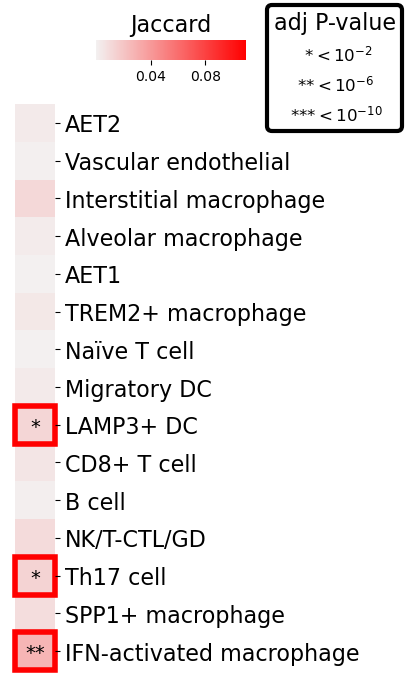

In [45]:
# We want to keep same order as PTB scRNA-seq 
sub_index = df_ptb[list(df_ptb_keys.values())].T.index
row_order = ptb_hm.dendrogram_row.reordered_ind

plot_heatmap_no_clust(
    microXptb_dfs[2].loc[sub_index.values[row_order]],
    cmap=red_cmap,
    filename=microXptb_star_path,
    xsize=0.5 / 0.94*1.1,
    ysize=microXptb_dfs[0].loc[sub_index.values[row_order]].shape[0] / 2*1.1,
    legendy=0.85,
    legendx=1.6,
    annot=microXptb_dfs[4].loc[sub_index.values[row_order]].map(stars)
)

/Users/jonathanperrie/miniconda3/envs/scvi/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


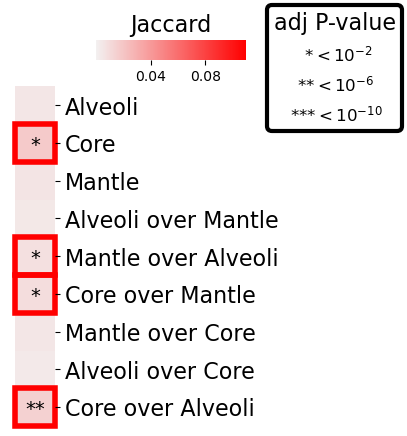

In [46]:
# ACM extended against antimicrobial gene set 
plot_heatmap_no_clust(
    micro_dfs[2],
    cmap=red_cmap,
    filename=micro_star_path,
    xsize=0.5 / 0.94*1.1,
    ysize=micro_dfs[0].shape[0] / 2*1.1,
    legendy=0.85,
    legendx=1.6,
    annot=micro_dfs[4].map(stars)
)

In [47]:
writer_dfs(*microXptb_dfs, microXptb_xls_path)
writer_dfs(*micro_dfs, micro_xls_path)